In [116]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import contractions
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.autonotebook import tqdm

tqdm.pandas()
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [118]:
train.head()

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive
3,3,i got this phone yesterday and didn ' t find a...,1,positive
4,4,1 ) price gb of storage,1,positive


In [119]:
train.label.value_counts()

1    1926
0    1090
Name: label, dtype: int64

In [120]:
train = train[["text", "label"]]

In [121]:
train.head()

,text,label
0,i really do recommend this to anyone in need o...,1
1,very good every day camera fits nicely in the ...,1
2,"but , dollar for dollar , this dvd player is p...",1
3,i got this phone yesterday and didn ' t find a...,1
4,1 ) price gb of storage,1


In [122]:
print(f"Hay {np.sum(train.text.duplicated())} duplicados")

Hay 4 noticias duplicadas


In [123]:
train = train.drop_duplicates()

In [124]:
np.sum(train.isnull())

text     0
label    0
dtype: int64

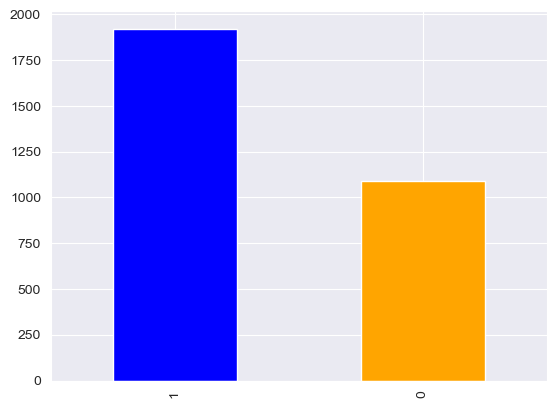

In [125]:
ax, fig = plt.subplots()
etiquetas = train.label.value_counts()
etiquetas.plot(kind='bar', color=["blue", "orange"])
plt.show()

# no diria que este desbalanceado

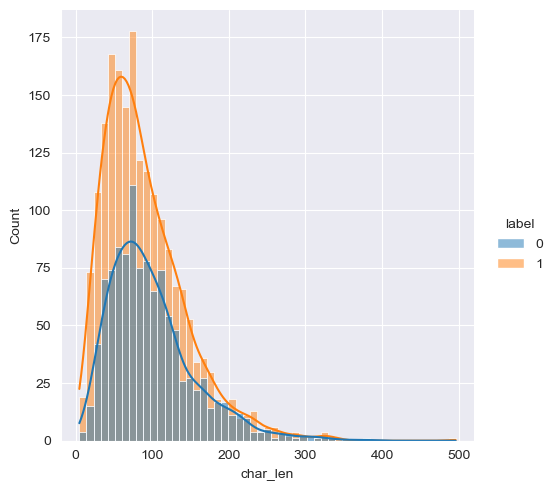

In [126]:
train["char_len"] = train["text"].apply(lambda x: len(x))

sns.displot(train, x="char_len", kde=True, hue="label")
plt.show()

# no hay ninguna diferencia real

In [133]:
train.drop(columns="char_len", inplace=True)

In [128]:
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    nlp = en_core_web_sm.load()

    tokens = word_tokenize(contractions.fix(" ".join(text.split()).lower()))
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = nlp(" ".join(tokens))
    tokens = [word.lemma_ for word in tokens]
    return " ".join(tokens)

In [129]:
train["clean_text"] = train["text"].progress_apply(lambda x: preprocess(x))

100%|██████████| 3012/3012 [20:58<00:00,  2.39it/s]


In [136]:
train.to_csv("../Data/clean_train.csv", sep="\t", index=False)
train = pd.read_csv('../Data/clean_train.csv', sep="\t")

In [135]:
train.head()

,text,label,clean_text
0,i really do recommend this to anyone in need o...,1,really recommend anyone need new player
1,very good every day camera fits nicely in the ...,1,good every day camera fit nicely pocket jean t...
2,"but , dollar for dollar , this dvd player is p...",1,dollar dollar dvd player probably well
3,i got this phone yesterday and didn ' t find a...,1,get phone yesterday find problem yet
4,1 ) price gb of storage,1,1 price gb storage


In [153]:
print(f"Hay {np.sum(train.clean_text.duplicated())} duplicados")
print(f"Hay {np.sum(train.clean_text.isnull())} vacios")

Hay 11 duplicados
Hay 0 vacios


In [152]:
train = train[~train.clean_text.isnull()]

100%|██████████| 3011/3011 [00:00<00:00, 299117.72it/s]


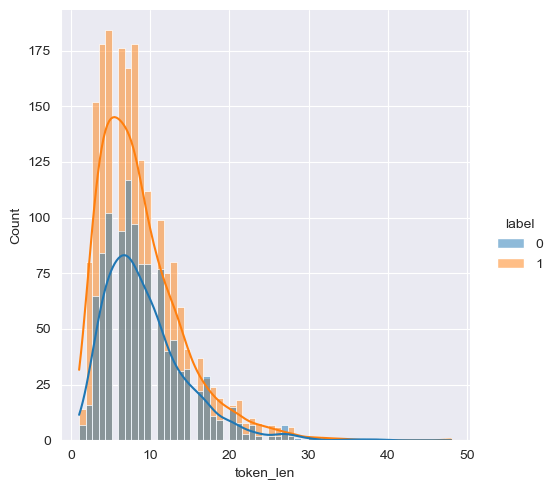

In [154]:
train["token_len"] = train["clean_text"].progress_apply(lambda x: len(x.split()))

sns.displot(train, x="token_len", kde=True, hue="label")
plt.show()

# no vemos ninguna diferencia

In [155]:
train.drop(columns="token_len", inplace=True)

In [216]:
train.clean_text
# vemos que hay numeros, los vamos a codificar por un valor unico

0                 really recommend anyone need new player
1       good every day camera fit nicely pocket jean t...
2                  dollar dollar dvd player probably well
3                    get phone yesterday find problem yet
4                                        price gb storage
                              ...                        
3007    itune find good window medium player computer ...
3008             play feature yet camera easy use get use
3009    application lot application work well eventual...
3010                                    battery non issue
3011     fm tuner  g storage removable disk great feature
Name: clean_text, Length: 3011, dtype: object

In [210]:
train["clean_text"] = train.clean_text.apply(lambda x: re.sub("\d+", '', x))

In [211]:
vectorizador = TfidfVectorizer(ngram_range=(1, 3), min_df=0.001).fit(train["clean_text"])
len(vectorizador.get_feature_names_out())

1521

In [212]:
vector_data = vectorizador.transform(train["clean_text"])

In [213]:
y = train["label"].values.astype(np.float32)

In [214]:
def model_evaluation(models, score, X, y):
    results = []
    names = []
    print(f'Metric: {score}')

    for name, model in models:
        KF = KFold(n_splits=10, shuffle=True, random_state=98)

        cv_results = cross_val_score(model, X, y, cv=KF, scoring=score, verbose=False)

        results.append(cv_results)
        names.append(name)

        print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

    # return results, names

In [215]:
models = [
    ("Logistic", LogisticRegression(random_state=30)),
    # ("GaussianNB", GaussianNB()),
    # ("DecisionTreeClassifier", DecisionTreeClassifier()),
    # ("RF", RandomForestClassifier())
]

# evaluation_score = "f1_macro"
evaluation_score = "accuracy"

model_evaluation(models, evaluation_score, vector_data.toarray(), y)

Metric: accuracy
Logistic: 0.768509 (0.022448) 
GaussianNB: 0.615405 (0.029701) 
DecisionTreeClassifier: 0.691801 (0.020126) 


KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vector_data, y, random_state=0)